# Models
---
With all the data being rescraped and cleaned the way it is, we have to run new models. 

The models are working now but we will have to probably start sampling soon since the current dataframe being imported is over 2 million rows!

In [39]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBRFClassifier, XGBClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, roc_curve, recall_score, precision_score

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report

import pickle

In [7]:
df = pd.read_csv('past_7_seasons_cleaned.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256848 entries, 0 to 2256847
Data columns (total 18 columns):
 #   Column             Dtype  
---  ------             -----  
 0   release_speed      float64
 1   release_pos_x      float64
 2   release_pos_z      float64
 3   stand              object 
 4   p_throws           object 
 5   type               object 
 6   pfx_x              float64
 7   pfx_z              float64
 8   plate_x            float64
 9   plate_z            float64
 10  vx0                float64
 11  vy0                float64
 12  vz0                float64
 13  ax                 float64
 14  ay                 float64
 15  az                 float64
 16  release_spin_rate  float64
 17  pitch_name         object 
dtypes: float64(14), object(4)
memory usage: 309.9+ MB


In [11]:
# Make a function to do the additional cleaning that was done after saving to a csv
def post_clean(df):
    
    # Rename 'type' (our target) to 'result'
    df.rename(columns={'type':'result'}, inplace=True)
    
    # Only want results that are S or B
    df = df.loc[((df['result'] == 'S') | (df['result'] == 'B'))]
    
    # Print out Null Accuracy
    print('The Null Accuracy:')
    print(df['result'].value_counts(normalize=True))
    
    # Make 'stand','p_throws', and 'result' binary columns
    # This shows that righties (R) are 1 while lefties (L) are 0
    # As well as strikes (S) being represented as 1 and balls (B) as 0
    df['result'] = np.where(df['result'] == 'S', 1, 0)
    df['stand'] = np.where(df['stand'] == 'R', 1, 0)
    df['p_throws'] = np.where(df['p_throws'] == 'R', 1, 0)
    
    # Rename the columns
    df.rename(columns={'stand':'batter_stance','p_throws':'pitchers_throwing_hand','result':'result'},inplace=True)
    
    # We will make a copy of the dataframe to create a df to dummify the original
    df2 = df.copy()
    
    # Drop the pitch_name from df2 copy
    df2 = df2.loc[:, df2.columns != 'pitch_name']
    
    # Dummify pitch names on original df
    df = pd.get_dummies(df, columns=['pitch_name'], prefix='pitch', drop_first=True)
    
    return df, df2

In [12]:
df, df2 = post_clean(df)

The Null Accuracy:
B    0.666414
S    0.333586
Name: result, dtype: float64


<ipython-input-11-14f528666e86>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['result'] = np.where(df['result'] == 'S', 1, 0)
<ipython-input-11-14f528666e86>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stand'] = np.where(df['stand'] == 'R', 1, 0)
<ipython-input-11-14f528666e86>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [16]:
df.result.value_counts(normalize=True)

0    0.666414
1    0.333586
Name: result, dtype: float64

In [14]:
params = ({
    'n_estimators':[100,150,200],
    'max_depth':[2,3,4,5],
    'max_features':['log2','auto']
})

In [19]:
X = df2.loc[:, df2.columns!='result'] # A matrix containing features we want
y = df2.result # A vector we are aiming for
X.head()

,release_speed,release_pos_x,release_pos_z,batter_stance,pitchers_throwing_hand,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate
0,96.1,-1.92,5.95,1,1,-0.27,1.70,-0.93,1.62,3.08,-139.61,-9.72,-2.03,34.78,-11.71,2463.0
1,93.6,-1.25,6.06,1,1,0.32,0.80,2.92,2.23,10.09,-135.73,-5.82,6.08,26.36,-24.25,2724.0
2,97.6,-1.45,6.22,0,1,-0.26,1.52,-0.85,3.15,2.00,-141.92,-6.17,-1.82,34.59,-13.48,2255.0
3,92.0,-1.77,6.12,0,1,0.23,0.80,-0.05,2.70,3.69,-133.89,-4.47,4.71,26.80,-24.40,2755.0
4,86.8,-1.56,6.08,1,1,0.28,-0.66,-0.10,1.07,2.71,-126.33,-4.10,4.71,26.40,-41.76,2498.0


In [20]:
# Use train test split to split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=66)

In [21]:
# Check the splits are correct
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1692633, 16), (564212, 16), (1692633,), (564212,))

In [24]:
rf = RandomizedSearchCV(RandomForestClassifier(),
                        param_distributions=params,
                        n_jobs=4,
                        verbose=2,
                        random_state=66)

In [25]:
rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 35.9min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 54.3min finished


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=4,
                   param_distributions={'max_depth': [2, 3, 4, 5],
                                        'max_features': ['log2', 'auto'],
                                        'n_estimators': [100, 150, 200]},
                   random_state=66, verbose=2)

In [26]:
print(f'Train score: {rf.score(X_train, y_train)}')
print(f'Test score: {rf.score(X_test, y_test)}')
rf.best_params_

Train score: 0.912073674565012
Test score: 0.912290061182676


{'n_estimators': 200, 'max_features': 'auto', 'max_depth': 5}

In [27]:
preds = rf.predict(X_test)
accuracy_score(y_test, preds)

0.912290061182676

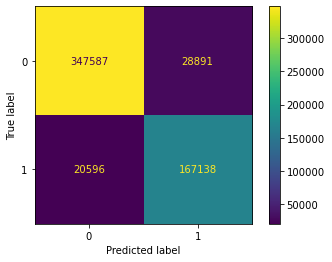

In [28]:
# Confusion Matrix
plot_confusion_matrix(rf, X_test, y_test)
plt.show()

In [31]:
confusion = confusion_matrix(y_test, preds)
print(confusion)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[347587  28891]
 [ 20596 167138]]


In [34]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(accuracy_score(y_test, preds))

0.912290061182676
0.912290061182676


This is the Classification Accuracy, how often is it correct.

---
Below is how often is it wrong, classification error.

In [36]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - accuracy_score(y_test, preds))

0.08770993881732399
0.08770993881732403


Next, we calculate sensitivity and specificity.

Sensitivity - When the actual value is positive, how often is the prediction correct?
- This needs to me maximized as much as possible
- We need true positive rate or "recall"

Specificity - When the actual value is negative, how often is the prediction correct?
- We also need to maximize on this
- How "selective" is the classifier at detecting positive instances

In [38]:
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(recall_score(y_test, preds))

specificity = TN / (TN + FP)

print(specificity)

0.890291582771368
0.890291582771368
0.9232597920728436


The classifer we just ran is both high in sensitivity and specificity. Meaning we are pretty accurate with our results. But considering it is not 100% shows that there is error in the classifier or that umpires are truly not perfect.

---

The last things we need are false positive rate (if the actual value is a ball, then how often are we incorrect) and precision (if the strike is predicted, how often is the prediction correct)

In [40]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

precision = TP / float(TP + FP)

print(precision)
print(precision_score(y_test, preds))

0.07674020792715644
0.07674020792715641
0.8526187451856613
0.8526187451856613


# Question

Has umpiring gotten better in making ball and strike calls? In order to answer that, we will set up a model to run on the same parameters as the one above.

In [ ]:
# Import all the